# Classifier

1. Logistic regression (https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python)


functions:
https://scikit-learn.org/stable/modules/feature_selection.html

example:
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

tut:
https://medium.com/@GouthamPeri/pipeline-with-tuning-scikit-learn-b2789dca9dc2

https://stackoverflow.com/questions/33376078/python-feature-selection-in-pipeline-how-determine-feature-names

## Import packages

In [55]:
import pandas as pd
from tqdm.notebook import tqdm
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [42]:
df = pd.read_pickle("wordlists_author.pkl")
df.head()
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422 entries, 0 to 421
Data columns (total 24259 columns):
 #      Column                                                       Dtype  
---     ------                                                       -----  
 0      index                                                        int64  
 1      author                                                       object 
 2      complete_body                                                object 
 3      doc_body                                                     object 
 4      probody                                                      object 
 5      tokens                                                       object 
 6      senttokens                                                   object 
 7      agreeableness                                                float64
 8      openness                                                     float64
 9      conscientiousness                    

In [20]:
authorlst = df['author'].tolist()
authorset = set(authorlst)
print ("Number of authors: ", len(authorset))

Number of authors:  422


In [21]:
n_bins = 20

def hist_true(df, trait):
    fig, ax = plt.subplots()
    plt.hist(df[trait], bins = 20)
    plt.title(trait, y=1.1)
    plt.xlabel("score")

# hist_true(df, "openn")

def all_hist_true(df):
    plt.figure(figsize = (16, 8))
#     plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.subplot(2, 3, 1)
    plt.hist(df['agreeableness'], bins = 20)
    plt.title('Agreeableness')
    
    plt.subplot(2, 3, 2)
    plt.hist(df['openness'], bins = 20)
    plt.title('Openness')
    
    plt.subplot(2, 3, 3)
    plt.hist(df['conscientiousness'], bins = 20)
    plt.title('Conscientiousness')
    
    plt.subplot(2, 3, 4)
    plt.hist(df['extraversion'], bins = 20)
    plt.title('Extraversion')
    
    plt.subplot(2, 3, 5)
    plt.hist(df['neuroticism'], bins = 20)
    plt.title('Neuroticism')
    
    plt.suptitle("Histograms of the true trait values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()


## Trait

In [22]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, trait_name, startnumber):
    featurelist = df.columns.tolist()
    feature_cols = featurelist[startnumber:]
#     print(len(feature_cols))
    x = df[feature_cols] 
    
    if trait_name == 'agree':
        y = df.agree
    elif trait_name == 'openn':
        y = df.openn
    elif trait_name == 'consc':
        y = df.consc
    elif trait_name == 'extra':
        y = df.extra
    elif trait_name == 'neuro':
        y = df.neuro       
    return x,y 

## Classifier

1. Logistic regression

In [23]:
def logclassifier(x_train,y_train, x_test):
    # instantiate the model (using the default parameters)
    logreg = LogisticRegression()
    # fit the model with data
    logreg.fit(x_train,y_train)
#     y_pred=logreg.predict(x_test)    
    return logreg

# logreg = logclassifier(x_train,y_train, x_test)
# y_pred=logreg.predict(x_test)



# ANOVA feature selection for numeric input and categorical output

def create_pipeline(x_train, y_train ,classifier):
    if classifier == "log":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('feature_selection',  SelectKBest(f_classif, k=30)),
          ('scaler', StandardScaler()),
          ('classification',LogisticRegression(n_jobs=-1))
        ])
        
    pipeline.fit(x_train, y_train)
    return pipeline





# logpipe = create_pipeline('log')
# y_pred=logpipe.predict(x_test)

# print("shape of x before feature selection", x.shape)
# x_new = SelectKBest(f_classif, k=30).fit_transform(x, y)
# print("shape of x after feature selection", x_new.shape)

## Get names of 30 most important features

In [24]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names

# names = get_names(logpipe)
# print(names)

### Get p-values

In [25]:
def get_pvalues(pipeline):
#     x_indices = np.arange(x.shape[-1])
#     selector = SelectKBest(f_classif, k=30)
#     selector.fit(x_train, y_train)
#     scores = -np.log10(selector.pvalues_)
    features = pipeline.named_steps['feature_selection']
    pvalues = features.pvalues_
    pvalues /= pvalues.max()
    fig, ax = plt.subplots()
    plt.hist(pvalues)
    plt.show()
    
    return pvalues

## Scores

In [50]:
def scores(y_test, y_pred, presentationtype):
    
    if presentationtype == "scores":
        accuracy=metrics.accuracy_score(y_test, y_pred)
        precision=metrics.precision_score(y_test, y_pred)
        recall=metrics.recall_score(y_test, y_pred)
        f_one=metrics.f1_score(y_test, y_pred)
        return accuracy, precision, recall, f_one
    if presentationtype == "report":
        report = classification_report(y_test, y_pred)
        return report


def score_plot(logreg, y_test, x_test):
    lr_probs = logreg.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
#     yhat = logreg.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
#     lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig, ax = plt.subplots()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    
    return lr_precision, lr_recall


### Score plot
Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.


Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

## Create and print confusion matrix

In [51]:
def create_cnfmatrix(y_test, y_pred, plotting=True):
    cnfpipe_matrix = metrics.confusion_matrix(y_test, y_pred)
#     print(cnfpipe_matrix)
#     disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cnfpipe_matrix)
#     disp.plot() 
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    sumpositive = tp + fn
    sumnegative = fp + tn
    sumcorrect = tp + tn
    sumwrong = fp + fn
    sumall = tn+fp+fn+tp
    print("TN, FP, FN, TP: ", tn, fp, fn, tp, "\nSum: ", sumall, "\nSum correct predictions: ", 
          sumcorrect, "Percent: ", sumcorrect/sumall, "\nSum wrong predictions: ", sumwrong, "\tPercent: ",
          sumwrong/sumall, "\nSum actual positives: ", sumpositive, "\tPercent: ", sumpositive/sumall,
          "\nSum actual negatives: ", sumnegative, "\tPercent: ", sumnegative/sumall)
    
    if plotting:
        %matplotlib inline
        class_names=[0,1] # name  of classes
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        # create heatmap
        sns.heatmap(pd.DataFrame(cnfpipe_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
        ax.xaxis.set_label_position("bottom")
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        
# cnfmatrix = create_cnfmatrix(y_test, y_pred, True)

# Wrapper

In [52]:
def classify(df, trait_name, startnumber, plotting=True):
    print("Trait to predict: ", trait_name)
    x,y = trait(df, trait_name, startnumber)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
    print("Number of authors in y_train: ", len(y_train))
    print("Number of authors in y_test: ", len(y_test))
    logpipe = create_pipeline(x_train, y_train, 'log')
    y_pred=logpipe.predict(x_test)
    print("Number of authors in y_pred: ", len(y_pred))
    names = get_names(x, logpipe)
    print("Names of the top", len(names), "features: \n", names, "\n")
    pvalues = get_pvalues(logpipe)
    print("p-values of", len(pvalues), "features: \n", pvalues, "\n")
    cnfmatrix = create_cnfmatrix(y_test, y_pred, plotting=True) 
#     accuracy, precision, recall, f_one = scores(y_test, y_pred, "scores")
#     print("Scores:\nAccuracy:",accuracy, "\nPrecision:",precision, "\nRecall:",recall, "\nF1 score:",f_one)
    report = scores(y_test, y_pred, "report")
    print("Classification report: \n", report)
    lr_precision, lr_recall = score_plot(logpipe, y_test, x_test)
#     print("Scores:\nLR_Precision:",lr_precision, "\nLR_Recall:",lr_recall)

# startnumber ngrams : 36
# startnumber wordlists: 29
# startnumber: linguistic features: 30
# startnumber: authorversion with arrays in user features: 26
start = 26
print ("Number of authors: ", len(authorset))

Number of authors:  422


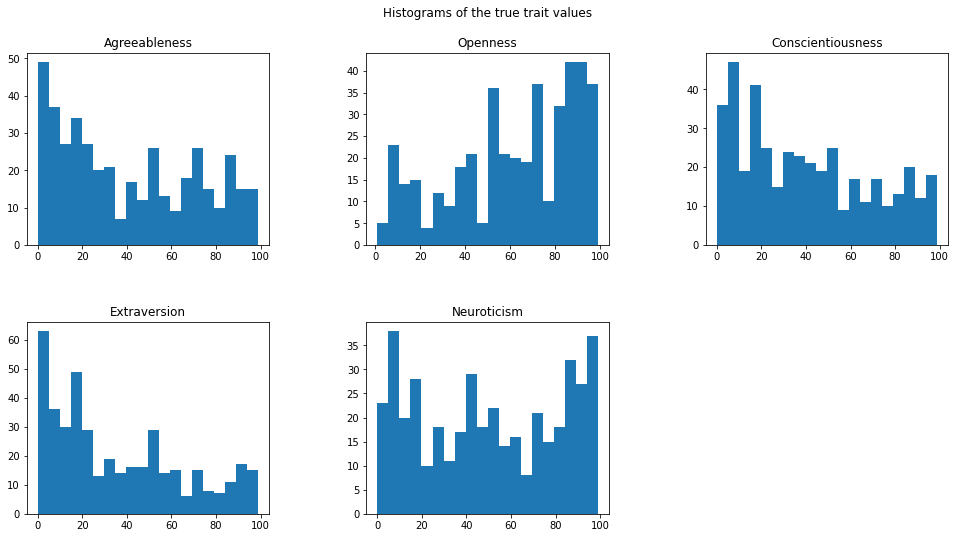

In [53]:
# true histogram plots
all_hist_true(df)

Trait to predict:  agree
Number of authors in y_train:  316
Number of authors in y_test:  106


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  106
Names of the top 30 features: 
 Index(['probably vegetative', 'scandal', 'since read book',
       'small party witney', 'society led intellectuals', 'spamming',
       'spamming whm 20s', 'specifically', 'spectrum yes no',
       'spell certainly', 'still go damage', 'supporting health society',
       'term goal would', 'term governments', 'thing modelling',
       'time got minecraft', 'time making', 'times starting repeat',
       'two three strong', 'use tertiary', 'vaping like switching',
       'war really', 'watched', 'weapon rouse', 'whm using regen',
       'whompcomic com two', 'win top', 'worth see social', 'www youtube',
       'yet would'],
      dtype='object') 



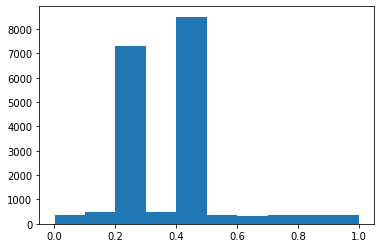

p-values of 18939 features: 
 [0.16947756 0.14050989 0.09920519 ... 0.05439906 0.67342401 0.78915662] 

TN, FP, FN, TP:  46 15 32 13 
Sum:  106 
Sum correct predictions:  59 Percent:  0.5566037735849056 
Sum wrong predictions:  47 	Percent:  0.44339622641509435 
Sum actual positives:  45 	Percent:  0.42452830188679247 
Sum actual negatives:  61 	Percent:  0.5754716981132075
Classification report: 
               precision    recall  f1-score   support

           0       0.59      0.75      0.66        61
           1       0.46      0.29      0.36        45

    accuracy                           0.56       106
   macro avg       0.53      0.52      0.51       106
weighted avg       0.54      0.56      0.53       106



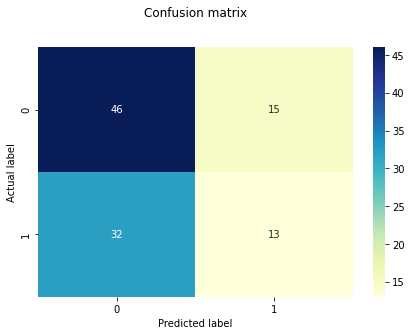

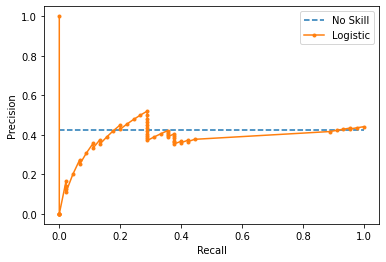

In [56]:
# Agreeableness
classify(df, "agree", start, plotting=True)

In [ ]:
# Openness
classify(df, "openn", start, plotting=True)

Trait to predict:  consc
Number of authors in y_train:  316
Number of authors in y_test:  106


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  106
Names of the top 30 features: 
 Index(['even without knowing', 'got lucky landed', 'let give hypothetical',
       'self', 'sensing', 'sensing dominant example', 'simulator',
       'skate lean', 'skinny hairless', 'somewhere along', 'somewhere gone',
       'standard scoringi need', 'strong', 'sure good collection',
       'thank need', 'thank posting', 'theory', 'things reason',
       'thinking necessary get', 'three hundred', 'tine', 'toolbox calling',
       'tournament species', 'trigger ideas gather', 'way flavor',
       'work probably worth', 'would limited', 'xsfp', 'yet dunno figure',
       'yield'],
      dtype='object') 



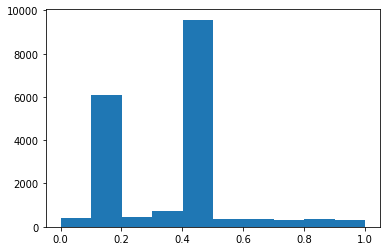

p-values of 18939 features: 
 [0.53291456 0.62225788 0.47468619 ... 0.97076023 0.03937743 0.76381823] 

TN, FP, FN, TP:  45 17 32 12 
Sum:  106 
Sum correct predictions:  57 Percent:  0.5377358490566038 
Sum wrong predictions:  49 	Percent:  0.46226415094339623 
Sum actual positives:  44 	Percent:  0.41509433962264153 
Sum actual negatives:  62 	Percent:  0.5849056603773585
Scores:
Accuracy: 0.5377358490566038 
Precision: 0.41379310344827586 
Recall: 0.2727272727272727 
F1 score: 0.32876712328767127


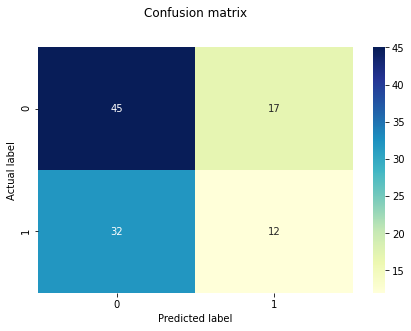

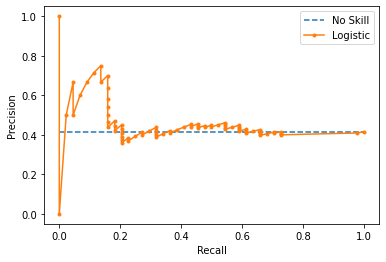

In [47]:
# Conscientiousness
classify(df, "consc", start, plotting=True)

Trait to predict:  extra
Number of authors in y_train:  316
Number of authors in y_test:  106


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  106
Names of the top 30 features: 
 Index(['ever stating', 'like truly', 'received pretty chill',
       'resources block wrong', 'sch malefic', 'see eyes', 'skal spare',
       'small party', 'small party witney', 'social policies', 'som',
       'som før men', 'start using', 'strength', 'strength work would',
       'sync nimblebit', 'system zen', 'think stoicism functional',
       'thousand four hundred', 'together organized', 'tone voice rhythm',
       'unhealthy', 'value educational purpose', 'varied results stable',
       'wait know', 'war really', 'way company getting', 'would imagine',
       'would know', 'yes yes tell'],
      dtype='object') 



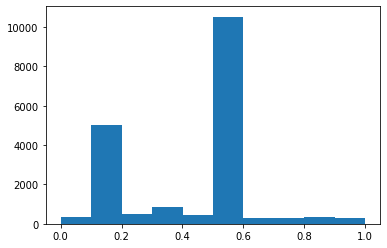

p-values of 18939 features: 
 [0.37672185 0.51977646 0.21630105 ... 0.21165926 0.9769304  0.42243125] 

TN, FP, FN, TP:  54 11 34 7 
Sum:  106 
Sum correct predictions:  61 Percent:  0.5754716981132075 
Sum wrong predictions:  45 	Percent:  0.42452830188679247 
Sum actual positives:  41 	Percent:  0.3867924528301887 
Sum actual negatives:  65 	Percent:  0.6132075471698113
Scores:
Accuracy: 0.5754716981132075 
Precision: 0.3888888888888889 
Recall: 0.17073170731707318 
F1 score: 0.23728813559322035


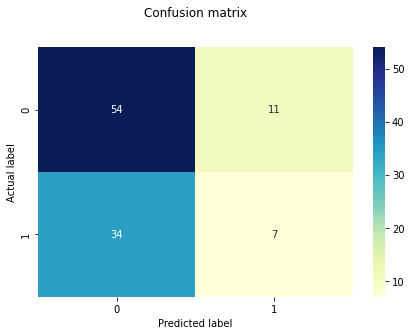

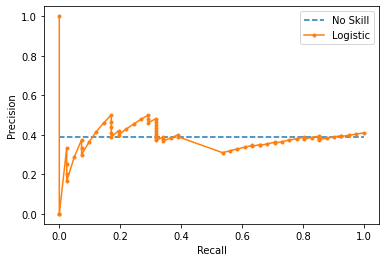

In [48]:
# Extraversion 
classify(df, "extra", start, plotting=True)

Trait to predict:  neuro
Number of authors in y_train:  316
Number of authors in y_test:  106


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  106
Names of the top 30 features: 
 Index(['presencetense', 'even without knowing', 'received pretty chill', 'sd',
       'security whatever', 'see attributing symptom',
       'self surrounding events', 'six two', 'sixteen', 'sleep plans', 'spare',
       'sure contrived thats', 'sure getting', 'talking thinking mean',
       'thebiggipper', 'three media tumblr', 'three zero warriors',
       'time fnatic strim', 'time not overwhelmed', 'transcends time well',
       'trying instill forsakes', 'type hot', 'ult global clone',
       'unfortunately tends inspire', 'violent incarcerated',
       'whenever things', 'whm kind assumed', 'work type',
       'would releverage get', 'would sayedit'],
      dtype='object') 



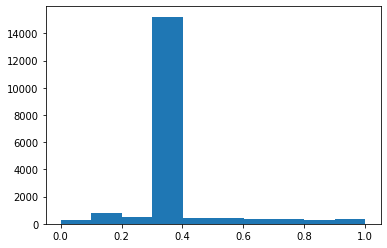

p-values of 18939 features: 
 [0.69264461 0.74741178 0.71404899 ... 0.45019142 0.02234462 0.46101305] 

TN, FP, FN, TP:  27 27 22 30 
Sum:  106 
Sum correct predictions:  57 Percent:  0.5377358490566038 
Sum wrong predictions:  49 	Percent:  0.46226415094339623 
Sum actual positives:  52 	Percent:  0.49056603773584906 
Sum actual negatives:  54 	Percent:  0.5094339622641509
Scores:
Accuracy: 0.5377358490566038 
Precision: 0.5263157894736842 
Recall: 0.5769230769230769 
F1 score: 0.5504587155963302


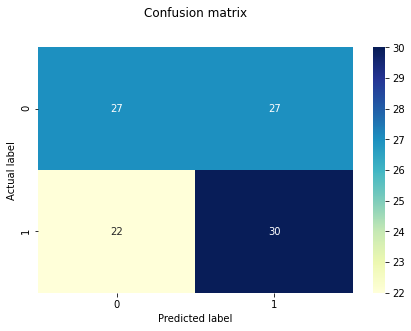

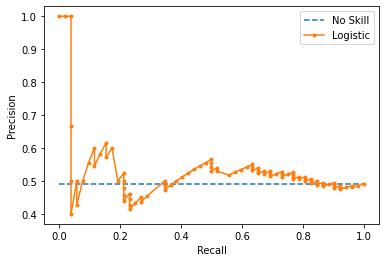

In [49]:
# Neuroticism
classify(df, "neuro", start, plotting=True)